<a href="https://colab.research.google.com/github/poring3995/My_Project/blob/main/Sensor%26Camera_control_simulation(Haar%20Cascade%20Classifier).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
import numpy as np

In [115]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [116]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

# **อันนี้**

In [117]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData, count, ck) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      if (count != 5 ) {
        if (ck == 0) {
      var preCreate = Date.now();
      stream = await createDom();
        }

      }

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox, count , ck):
  data = eval_js('stream_frame("{}", "{}","{}","{}")'.format(label, bbox, count, ck))
  return data

In [123]:
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow
import sys

def display_images(folder):
    # List all files in the folder
    files = os.listdir(folder)
    # Filter out only image files
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    # Read and display each image
    for image_file in image_files:
        image_path = os.path.join(folder, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            cv2_imshow(image)

def save_frames(frames, start_index):
    pass_folder = 'pass'
    if not os.path.exists(pass_folder):
        os.makedirs(pass_folder)

    # Find the index of the last saved frame
    existing_frames = os.listdir(pass_folder)
    last_index = start_index + len(existing_frames)

    # Save new frames with incremented indices
    for i, frame in enumerate(frames):
        cv2.imwrite(os.path.join(pass_folder, f'frame_{last_index + i}.jpg'), frame)



# Main function
def main(ck):
    count = 0
    # start streaming video from webcam
    video_stream()
    # label for video
    label_html = 'Capturing...'
    # initialze bounding box to empty
    bbox = ''

    frames_to_save = []

    while True:

        js_reply = video_frame(label_html, bbox, count, ck)
        if not js_reply:
            break

        # convert JS response to OpenCV Image
        img = js_to_image(js_reply["img"])

        # create transparent overlay for bounding box
        bbox_array = np.zeros([480,640,4], dtype=np.uint8)

        # grayscale image for face detection
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # get face region coordinates
        faces = face_cascade.detectMultiScale(gray)
        # get face bounding box for overlay
        for (x,y,w,h) in faces:
            bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

        bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
        # convert overlay of bbox into bytes
        bbox_bytes = bbox_to_bytes(bbox_array)
        # update bbox so next frame gets new overlay
        bbox = bbox_bytes

        if len(faces) > 0:
            count += 1
            if count >= 6:
                print("Face detected for 5 frames. Adding frames to the folder...")
                save_frames(frames_to_save, ck * 5)  # Pass the start index for new frames
                frames_to_save = []  # Reset frames_to_save list
                count = 0
                #save_frames(frames_to_save)
                #frames_to_save = []
                #video_frame(label_html, bbox, count,ck)
                #count = 0
                break
                # Don't reset frames_to_save, append new frames instead
            else:
                # Append frames to frames_to_save
                frames_to_save.extend([img] * len(faces))


    print("Done\n")

ck = 0
while True :
  print("Waiting for sensor signal....")
  sys.stdout.write("Press spacebar to start streaming / q to quit: ")
  sys.stdout.flush()  # Flush the output buffer to ensure prompt is displayed
  input_str = input()
  # Wait for input
  if input_str == ' ':  # Check if input is spacebar
    print("Streaming started...")
    if __name__ == "__main__":
      main(ck)
      ck = ck + 1
  elif input_str == 'q':
    break

Waiting for sensor signal....
Press spacebar to start streaming / q to quit:  
Streaming started...


<IPython.core.display.Javascript object>

Face detected for 5 frames. Adding frames to the folder...
Done

Waiting for sensor signal....
Press spacebar to start streaming / q to quit: q


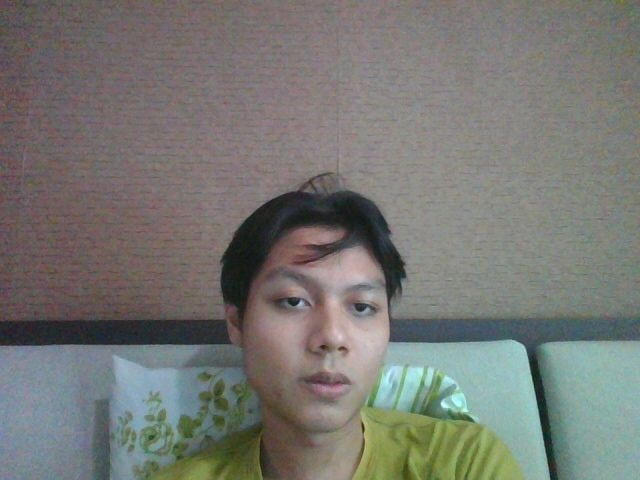

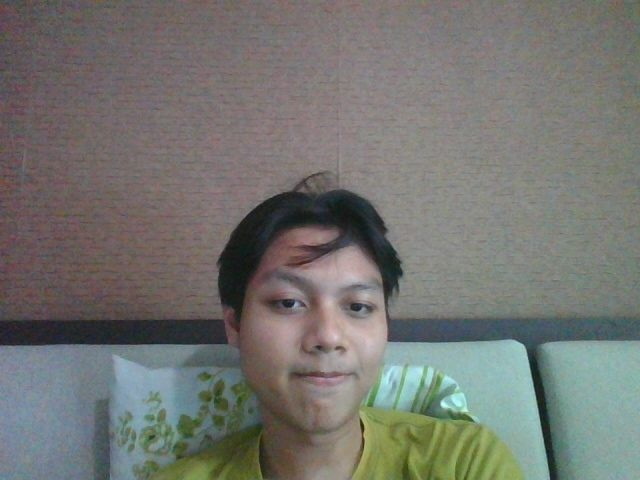

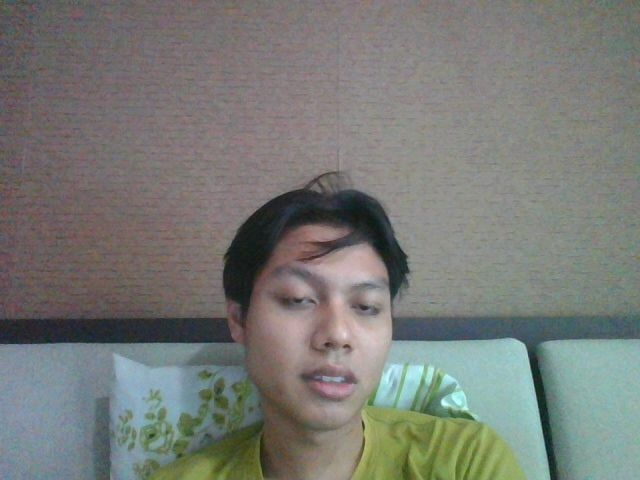

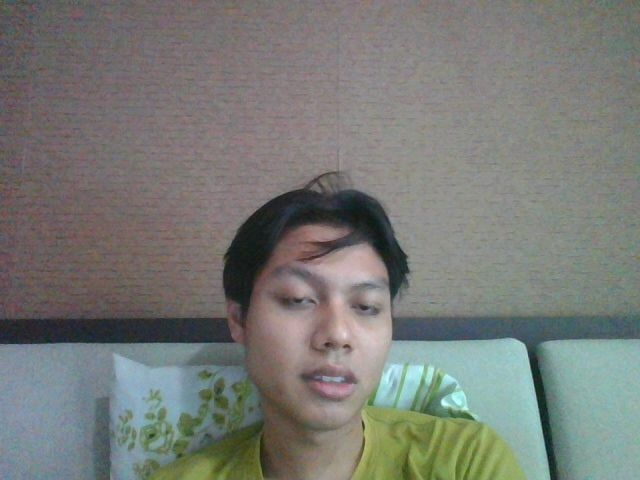

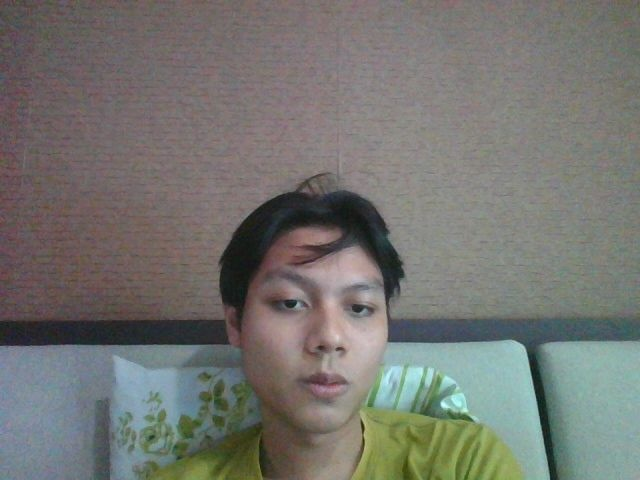

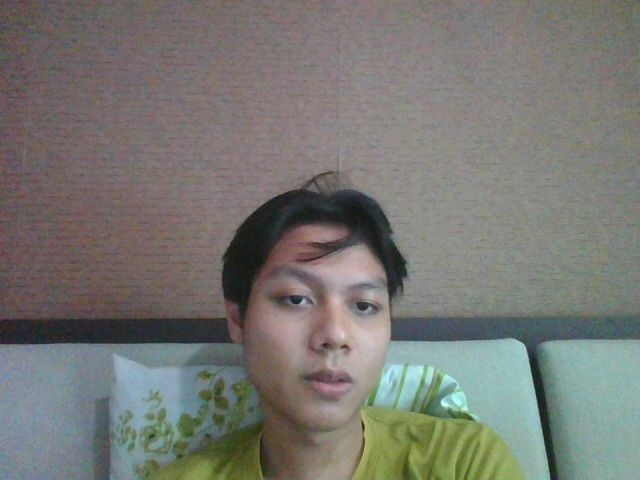

In [124]:
display_images('/content/pass')

In [120]:
!rm -rf /content/pass